NameError: name 'resample' is not defined

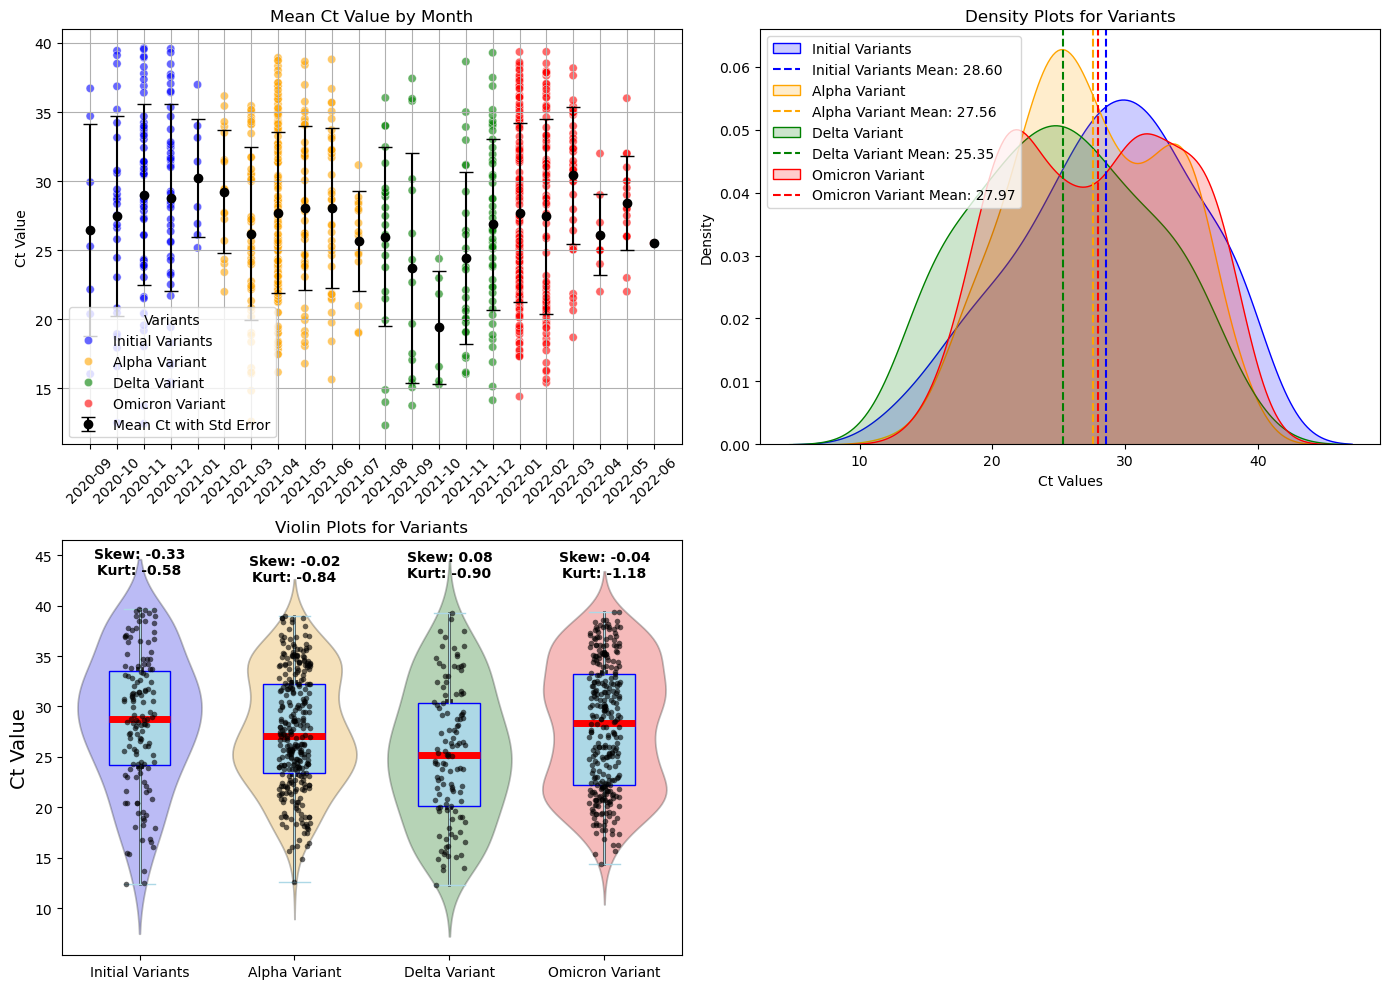

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew

# Φόρτωση του Excel αρχείου
file_path = os.path.join(os.path.expanduser("~"), "Desktop", "dedomena", "ΘΕΤΙΚΑ.xlsx")
df = pd.read_excel(file_path, engine='openpyxl')

# Μετατροπή των τιμών της στήλης 'ct' σε αριθμητική μορφή και αφαίρεση μη έγκυρων τιμών
df['ct'] = pd.to_numeric(df['ct'], errors='coerce')

# Αφαίρεση κενών τιμών στις στήλες που χρησιμοποιούμε
df = df.dropna(subset=['date', 'ct'])

# Μετατροπή της στήλης ημερομηνιών σε datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

# Δημιουργία στήλης 'month' για την ομαδοποίηση και μετατροπή σε συμβολοσειρά
df['month'] = df['date'].dt.to_period('M').astype(str)

# Κατηγοριοποίηση ανά παραλλαγή βάσει χρονικών περιόδων
df['variant'] = pd.cut(df['date'], 
                       bins=[pd.Timestamp('2020-01-01'), pd.Timestamp('2021-01-31'), 
                             pd.Timestamp('2021-07-31'), pd.Timestamp('2021-12-31'), pd.Timestamp('2023-10-01')],
                       labels=['Initial Variants', 'Alpha Variant', 'Delta Variant', 'Omicron Variant'], 
                       include_lowest=True)

# Αφαίρεση μη έγκυρων τιμών από τη στήλη 'variant'
df = df.dropna(subset=['variant'])

# Define a color palette for each variant
colors = {
    'Initial Variants': 'blue',
    'Alpha Variant': 'orange',
    'Delta Variant': 'green',
    'Omicron Variant': 'red'
}

# Set up a figure with subplots
plt.figure(figsize=(14, 10))

# 1. Scatter plot with error bars
plt.subplot(2, 2, 1)
palette = colors
sns.scatterplot(data=df, x='month', y='ct', hue='variant', palette=palette, alpha=0.6)
monthly_avg = df.groupby('month').agg(Μέσος_Όρος_Ct=('ct', 'mean'), Σφάλμα=('ct', 'std')).reset_index()
plt.errorbar(monthly_avg['month'], monthly_avg['Μέσος_Όρος_Ct'], yerr=monthly_avg['Σφάλμα'], 
              fmt='o',color='black', label='Mean Ct with Std Error', capsize=5)
plt.title('Mean Ct Value by Month')
plt.xlabel('')
plt.ylabel('Ct Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Variants')

# 2. Density plots
plt.subplot(2, 2, 2)
mean_values = {}  # Dictionary to hold mean values
for variant in df['variant'].cat.categories:
    variant_data = df[df['variant'] == variant]['ct']
    mean_value = variant_data.mean()
    mean_values[variant] = mean_value  # Store mean value
    sns.kdeplot(variant_data, label=f'{variant}', fill=True, alpha=0.2, color=colors[variant])
    plt.axvline(mean_value, linestyle='--', color=colors[variant], label=f'{variant} Mean: {mean_value:.2f}')  # Vertical line for each variant mean

plt.title('Density Plots for Variants')
plt.xlabel('Ct Values')
plt.ylabel('Density')
plt.legend()

# 3. Violin plot
plt.subplot(2, 2, 3)
violin_plot = sns.violinplot(x='variant', y='ct', data=df, hue='variant', palette=colors, alpha=0.3, legend=False)

# Add dots in the violin plots
sns.stripplot(x='variant', y='ct', data=df, color='black', jitter=True, size=4, alpha=0.6)  # Dots in the violin plot

# Customize the appearance of the box inside the violin
for pc in violin_plot.patches:  # Loop through the patches (violin parts)
    pc.set_facecolor('lightcoral')  # Change this color to your desired one
    pc.set_edgecolor('red')  # Set edge color if needed

# Optionally adjust the box plot's properties (adjust this section)
plt.boxplot([df[df['variant'] == variant]['ct'] for variant in df['variant'].cat.categories],
            positions=range(len(df['variant'].cat.categories)), widths=0.4, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', color='blue'), 
            whiskerprops=dict(color='lightblue'), 
            capprops=dict(color='lightblue'), 
            medianprops=dict(color='red',linewidth=5))  # Optional for median line color

# Calculate skewness and kurtosis for each variant and annotate on the plot
for i, variant in enumerate(df['variant'].cat.categories):
    skew_val = skew(df[df['variant'] == variant]['ct'].dropna())
    kurt_val = kurtosis(df[df['variant'] == variant]['ct'].dropna())
    
   # Dynamically calculate the y position for the annotations
    y_max = df[df['variant'] == variant]['ct'].max() + 3.5  # Adjust height based on the maximum value with padding
    
    # Add text annotations for skewness and kurtosis
    plt.text(i, y_max, f'Skew: {skew_val:.2f}\nKurt: {kurt_val:.2f}', 
             horizontalalignment='center', size='medium', color='black', weight='semibold')


# Don't forget to label your axes and set the title as necessary
plt.title('Violin Plots for Variants', fontsize=14)
plt.ylabel('Ct Value', fontsize=14)
plt.xlabel('Variants', fontsize=14)


# Set x-axis labels for the variants
plt.xticks(ticks=range(len(df['variant'].cat.categories)), labels=df['variant'].cat.categories, rotation=0)

plt.title('Violin Plots for Variants')
plt.ylabel('Ct Value', fontsize=14)
plt.xlabel('', fontsize=14)
plt.tight_layout()



# 4. Kurtosis and skewness calculations
#kurtosis_values = [kurtosis(df[df['variant'] == variant]['ct'].dropna()) for variant in df['variant'].cat.categories]
#skewness_values = [skew(df[df['variant'] == variant]['ct'].dropna()) for variant in df['variant'].cat.categories]


# Συνάρτηση bootstrap για υπολογισμό διαστημάτων εμπιστοσύνης
def bootstrap_ci(data, stat_func, num_bootstrap=1000, ci_percentile=95):
    bootstrapped_stats = []
    for _ in range(num_bootstrap):
        sample = resample(data, replace=True)
        bootstrapped_stats.append(stat_func(sample))
    lower_bound = np.percentile(bootstrapped_stats, (100 - ci_percentile) / 2)
    upper_bound = np.percentile(bootstrapped_stats, 100 - (100 - ci_percentile) / 2)
    return lower_bound, upper_bound

# Υπολογισμός με bootstrap για το 95% CI για mean, median, kurtosis, skewness
variants = df['variant'].cat.categories
mean_values = []
mean_ci_lower = []
mean_ci_upper = []
median_values = []
median_ci_lower = []
median_ci_upper = []
kurtosis_values = []
kurtosis_ci_lower = []
kurtosis_ci_upper = []
skewness_values = []
skewness_ci_lower = []
skewness_ci_upper = []

for variant in variants:
    variant_data = df[df['variant'] == variant]['ct'].dropna()
    
    # Mean
    mean_value = np.mean(variant_data)
    mean_ci_l, mean_ci_u = bootstrap_ci(variant_data, np.mean)
    mean_values.append(mean_value)
    mean_ci_lower.append(mean_ci_l)
    mean_ci_upper.append(mean_ci_u)
    
    # Median
    median_value = np.median(variant_data)
    median_ci_l, median_ci_u = bootstrap_ci(variant_data, np.median)
    median_values.append(median_value)
    median_ci_lower.append(median_ci_l)
    median_ci_upper.append(median_ci_u)
    
    # Kurtosis
    kurtosis_value = kurtosis(variant_data)
    kurtosis_ci_l, kurtosis_ci_u = bootstrap_ci(variant_data, kurtosis)
    kurtosis_values.append(kurtosis_value)
    kurtosis_ci_lower.append(kurtosis_ci_l)
    kurtosis_ci_upper.append(kurtosis_ci_u)
    
    # Skewness
    skewness_value = skew(variant_data)
    skewness_ci_l, skewness_ci_u = bootstrap_ci(variant_data, skew)
    skewness_values.append(skewness_value)
    skewness_ci_lower.append(skewness_ci_l)
    skewness_ci_upper.append(skewness_ci_u)

# Σχεδιασμός γραφήματος
plt.subplot(2, 2, 4)

# Prepare x labels and values
x_labels = df['variant'].cat.categories

# Create the first y-axis for Mean and Median with error bars
ax1 = plt.gca()

# Mean with error bars
ax1.errorbar(x_labels, mean_values, yerr=[np.array(mean_values) - np.array(mean_ci_lower), 
                                          np.array(mean_ci_upper) - np.array(mean_values)], 
             marker='o', label='Mean', color='blue', linestyle='-', linewidth=2, capsize=5)

# Median with error bars
ax1.errorbar(x_labels, median_values, yerr=[np.array(median_values) - np.array(median_ci_lower), 
                                            np.array(median_ci_upper) - np.array(median_values)], 
             marker='s', label='Median', color='purple', linestyle='-', linewidth=2, capsize=5)

ax1.set_ylabel('Mean / Median', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create the second y-axis for Kurtosis and Skewness with error bars
ax2 = ax1.twinx()  # Create a second y-axis

# Kurtosis with error bars
ax2.errorbar(x_labels, kurtosis_values, yerr=[np.array(kurtosis_values) - np.array(kurtosis_ci_lower), 
                                              np.array(kurtosis_ci_upper) - np.array(kurtosis_values)], 
             marker='o', label='Kurtosis', color='red', linestyle='--', linewidth=2, capsize=5)

# Skewness with error bars
ax2.errorbar(x_labels, skewness_values, yerr=[np.array(skewness_values) - np.array(skewness_ci_lower), 
                                              np.array(skewness_ci_upper) - np.array(skewness_values)], 
             marker='o', label='Skewness', color='green', linestyle=':', linewidth=2, capsize=5)

ax2.set_ylabel('Kurtosis / Skewness', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add labels and title
plt.title('Mean, Median, Kurtosis, and Skewness with 95% CI by Variant')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


NameError: name 'bootstrap_ci' is not defined

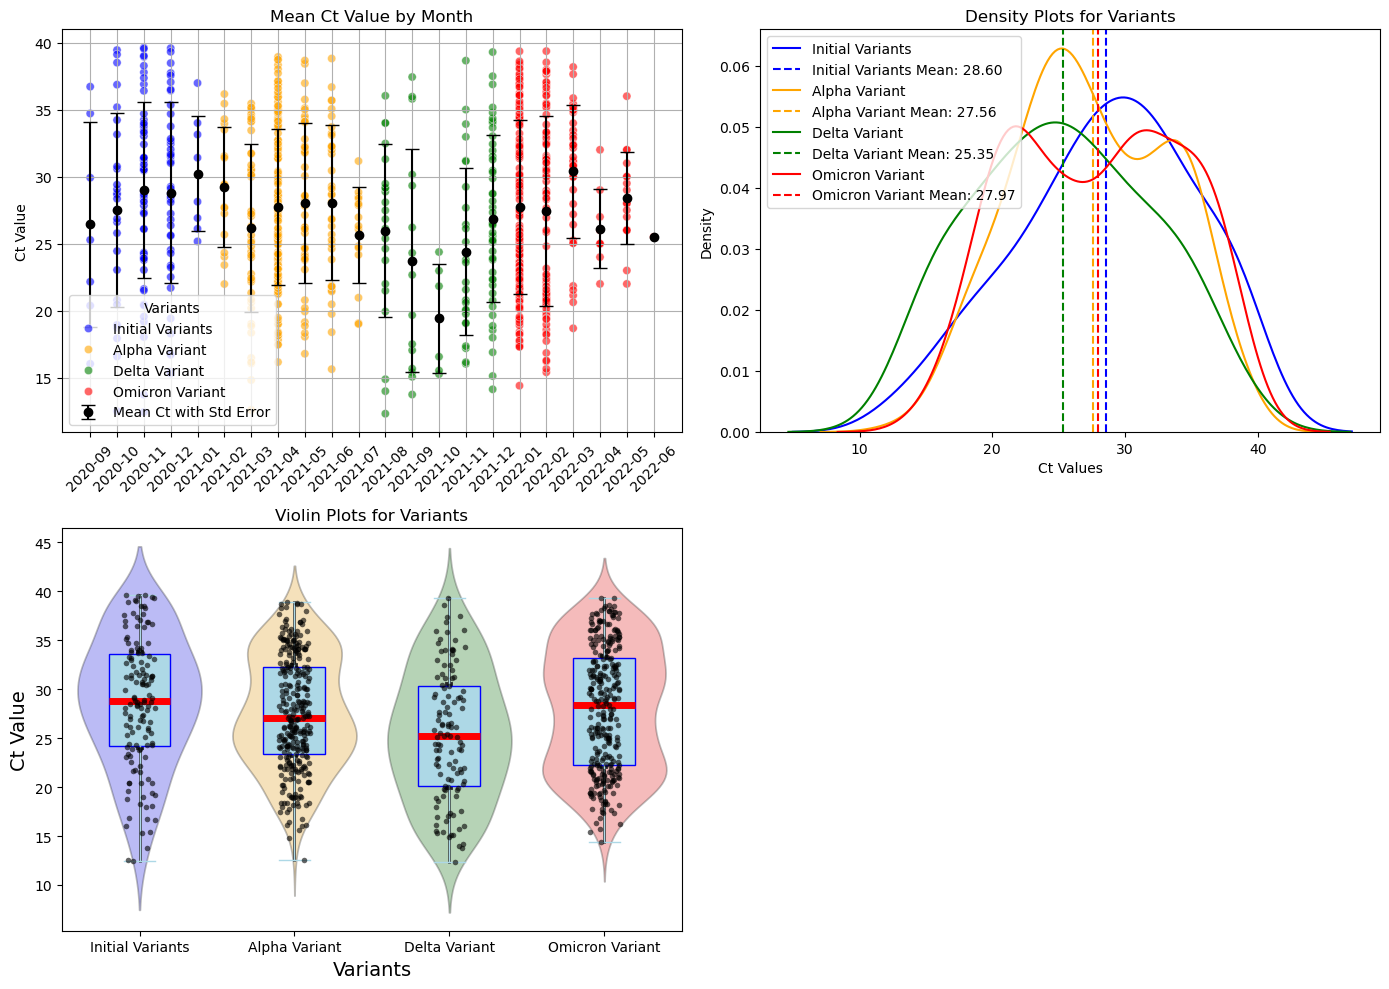

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew
from math import pi

# Φόρτωση του Excel αρχείου
file_path = os.path.join(os.path.expanduser("~"), "Desktop", "dedomena", "ΘΕΤΙΚΑ.xlsx")
df = pd.read_excel(file_path, engine='openpyxl')

# Μετατροπή των τιμών της στήλης 'ct' σε αριθμητική μορφή και αφαίρεση μη έγκυρων τιμών
df['ct'] = pd.to_numeric(df['ct'], errors='coerce')

# Αφαίρεση κενών τιμών στις στήλες που χρησιμοποιούμε
df = df.dropna(subset=['date', 'ct'])

# Μετατροπή της στήλης ημερομηνιών σε datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

# Δημιουργία στήλης 'month' για την ομαδοποίηση και μετατροπή σε συμβολοσειρά
df['month'] = df['date'].dt.to_period('M').astype(str)

# Κατηγοριοποίηση ανά παραλλαγή βάσει χρονικών περιόδων
df['variant'] = pd.cut(df['date'], 
                       bins=[pd.Timestamp('2020-01-01'), pd.Timestamp('2021-01-31'), 
                             pd.Timestamp('2021-07-31'), pd.Timestamp('2021-12-31'), pd.Timestamp('2023-10-01')],
                       labels=['Initial Variants', 'Alpha Variant', 'Delta Variant', 'Omicron Variant'], 
                       include_lowest=True)

# Αφαίρεση μη έγκυρων τιμών από τη στήλη 'variant'
df = df.dropna(subset=['variant'])

# Define a color palette for each variant
colors = {
    'Initial Variants': 'blue',
    'Alpha Variant': 'orange',
    'Delta Variant': 'green',
    'Omicron Variant': 'red'
}

# Set up a figure with subplots
plt.figure(figsize=(14, 10))

# 1. Scatter plot with error bars
plt.subplot(2, 2, 1)
palette = colors
sns.scatterplot(data=df, x='month', y='ct', hue='variant', palette=palette, alpha=0.6)
monthly_avg = df.groupby('month').agg(Μέσος_Όρος_Ct=('ct', 'mean'), Σφάλμα=('ct', 'std')).reset_index()
plt.errorbar(monthly_avg['month'], monthly_avg['Μέσος_Όρος_Ct'], yerr=monthly_avg['Σφάλμα'], 
              fmt='o', color='black', label='Mean Ct with Std Error', capsize=5)
plt.title('Mean Ct Value by Month')
plt.xlabel('')
plt.ylabel('Ct Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Variants')

# 2. Density plots χωρίς fill
plt.subplot(2, 2, 2)
mean_values = {}  # Dictionary to hold mean values
for variant in df['variant'].cat.categories:
    variant_data = df[df['variant'] == variant]['ct']
    mean_value = variant_data.mean()
    mean_values[variant] = mean_value  # Store mean value
    sns.kdeplot(variant_data, label=f'{variant}', color=colors[variant])
    plt.axvline(mean_value, linestyle='--', color=colors[variant], label=f'{variant} Mean: {mean_value:.2f}')  # Vertical line for each variant mean

plt.title('Density Plots for Variants')
plt.xlabel('Ct Values')
plt.ylabel('Density')
plt.legend()


# 3. Violin plot (Διατήρηση του αρχικού σας σχεδίου)
plt.subplot(2, 2, 3)
violin_plot = sns.violinplot(x='variant', y='ct', data=df, hue='variant', palette=colors, alpha=0.3, legend=False)

# Add dots in the violin plots
sns.stripplot(x='variant', y='ct', data=df, color='black', jitter=True, size=4, alpha=0.6)  # Dots in the violin plot

# Διατήρηση της παραμετροποίησης του box plot
plt.boxplot([df[df['variant'] == variant]['ct'] for variant in df['variant'].cat.categories],
            positions=range(len(df['variant'].cat.categories)), widths=0.4, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', color='blue'), 
            whiskerprops=dict(color='lightblue'), 
            capprops=dict(color='lightblue'), 
            medianprops=dict(color='red', linewidth=5))

plt.title('Violin Plots for Variants')
plt.ylabel('Ct Value', fontsize=14)
plt.xlabel('Variants', fontsize=14)

plt.xticks(ticks=range(len(df['variant'].cat.categories)), labels=df['variant'].cat.categories, rotation=0)
plt.tight_layout()

# Υπολογισμός με bootstrap για το 95% CI για mean, median, kurtosis, skewness
variants = df['variant'].cat.categories
mean_values = []
mean_ci_lower = []
mean_ci_upper = []
median_values = []
median_ci_lower = []
median_ci_upper = []
kurtosis_values = []
kurtosis_ci_lower = []
kurtosis_ci_upper = []
skewness_values = []
skewness_ci_lower = []
skewness_ci_upper = []

for variant in variants:
    variant_data = df[df['variant'] == variant]['ct'].dropna()
    
    # Mean
    mean_value = np.mean(variant_data)
    mean_ci_l, mean_ci_u = bootstrap_ci(variant_data, np.mean)
    mean_values.append(mean_value)
    mean_ci_lower.append(mean_ci_l)
    mean_ci_upper.append(mean_ci_u)
    
    # Median
    median_value = np.median(variant_data)
    median_ci_l, median_ci_u = bootstrap_ci(variant_data, np.median)
    median_values.append(median_value)
    median_ci_lower.append(median_ci_l)
    median_ci_upper.append(median_ci_u)
    
    # Kurtosis
    kurtosis_value = kurtosis(variant_data)
    kurtosis_ci_l, kurtosis_ci_u = bootstrap_ci(variant_data, kurtosis)
    kurtosis_values.append(kurtosis_value)
    kurtosis_ci_lower.append(kurtosis_ci_l)
    kurtosis_ci_upper.append(kurtosis_ci_u)
    
    # Skewness
    skewness_value = skew(variant_data)
    skewness_ci_l, skewness_ci_u = bootstrap_ci(variant_data, skew)
    skewness_values.append(skewness_value)
    skewness_ci_lower.append(skewness_ci_l)
    skewness_ci_upper.append(skewness_ci_u)

# 4. Radar chart με κλίμακα για καλύτερη ορατότητα
plt.subplot(2, 2, 4, polar=True)

# Κανονικοποίηση των τιμών και των διαστημάτων εμπιστοσύνης με MinMaxScaler
scaler = MinMaxScaler()

# Συγκέντρωση των δεδομένων σε έναν πίνακα για κανονικοποίηση
data = np.array([mean_values, median_values, kurtosis_values, skewness_values]).T
lower_bounds = np.array([mean_ci_lower, median_ci_lower, kurtosis_ci_lower, skewness_ci_lower]).T
upper_bounds = np.array([mean_ci_upper, median_ci_upper, kurtosis_ci_upper, skewness_ci_upper]).T

# Κανονικοποίηση των κεντρικών τιμών, lower bounds, και upper bounds
data_normalized = scaler.fit_transform(data)
lower_bounds_normalized = scaler.transform(lower_bounds)
upper_bounds_normalized = scaler.transform(upper_bounds)

# Κατηγορίες (Mean, Median, Kurtosis, Skewness)
categories = ['Mean', 'Median', 'Kurtosis', 'Skewness']
N = len(categories)

# Γωνίες για το radar chart
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Radar chart με κανονικοποιημένα δεδομένα και CI
ax = plt.subplot(2, 2, 4, polar=True)

for i in range(len(variants)):
    # Κανονικοποιημένες τιμές
    values = data_normalized[i].tolist()
    values += values[:1]  # Επαναλαμβάνουμε το πρώτο στοιχείο για να κλείσει το γράφημα

    # Κανονικοποιημένα lower και upper bounds για τα CI
    lower_values = lower_bounds_normalized[i].tolist()
    lower_values += lower_values[:1]
    upper_values = upper_bounds_normalized[i].tolist()
    upper_values += upper_values[:1]

    # Plot των κανονικοποιημένων τιμών
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=variants[i])
    
    # Προσθήκη error bands (περιοχή ανάμεσα στα CI)
    ax.fill_between(angles, lower_values, upper_values, alpha=0.1)

# Προσθήκη κατηγοριών στις ακτίνες
plt.xticks(angles[:-1], categories)

# Προσθήκη τίτλου και υπομνήματος
plt.title('Normalized Radar Chart with CI: Mean, Median, Kurtosis, and Skewness by Variant')
ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.tight_layout()
plt.show()


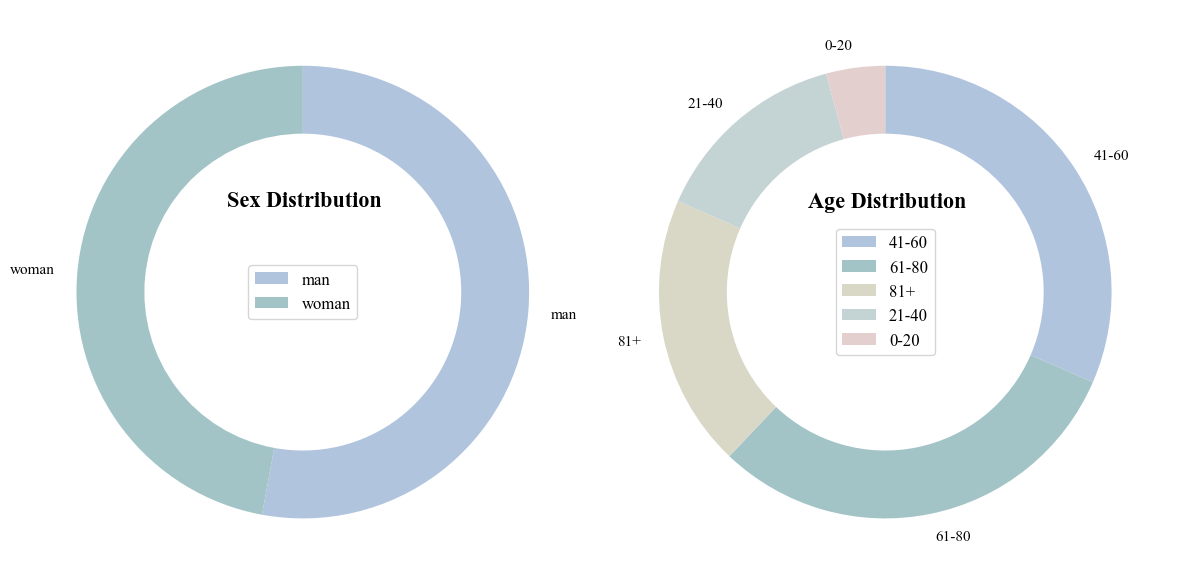

In [72]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the Excel file
file_path = os.path.join(os.path.expanduser("~"), "Desktop", "dedomena", "ΘΕΤΙΚΑ.xlsx")
df = pd.read_excel(file_path, engine='openpyxl')

# Clean the data by dropping NaN values in 'gender' and convert 'age' to numeric
df['age'] = pd.to_numeric(df['age'], errors='coerce')  # Convert 'age' to numeric
df = df.dropna(subset=['gender', 'age'])  # Drop NaN values

# Gender distribution
gender_counts = df['gender'].value_counts()

# Age distribution
age_bins = [0, 20, 40, 60, 80, 100]
age_labels = ['0-20', '21-40', '41-60', '61-80', '81+']
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)
age_counts = df['age_group'].value_counts()

# Set up the figure
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Ring chart for gender
ax[0].pie(gender_counts, labels=gender_counts.index, startangle=90, counterclock=False, 
          colors=['#B0C4DE', '#A3C4C7'], wedgeprops=dict(width=0.3))
ax[0].legend(gender_counts.index, loc='center', fontsize=12)
title = "Sex Distribution"
theta = np.linspace(0, 2 * np.pi, 100)
radius = 0.9  # Adjust this value to change how far from the center the text is placed
x = radius * np.cos(theta)
y = radius * np.sin(theta)
ax[0].text(np.mean(x), np.mean(y) + 0.4, title, ha='center', va='center', fontsize=16, fontweight='bold')


# Ring chart for age distribution with muted colors
muted_colors = ['#B0C4DE', '#A3C4C7', '#D9D8C7', '#C4D3D4', '#E4CFCF']  # Less bright colors
ax[1].pie(age_counts, labels=age_counts.index, startangle=90, counterclock=False, 
          colors=muted_colors, wedgeprops=dict(width=0.3))
ax[1].legend(age_counts.index, loc='center', fontsize=12)


# Curved title placement for age distribution
title = "Age Distribution"
theta = np.linspace(0, 2 * np.pi, 100)
radius = 0.9  # Adjust this value to change how far from the center the text is placed
x = radius * np.cos(theta)
y = radius * np.sin(theta)
ax[1].text(np.mean(x), np.mean(y) + 0.4, title, ha='center', va='center', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()


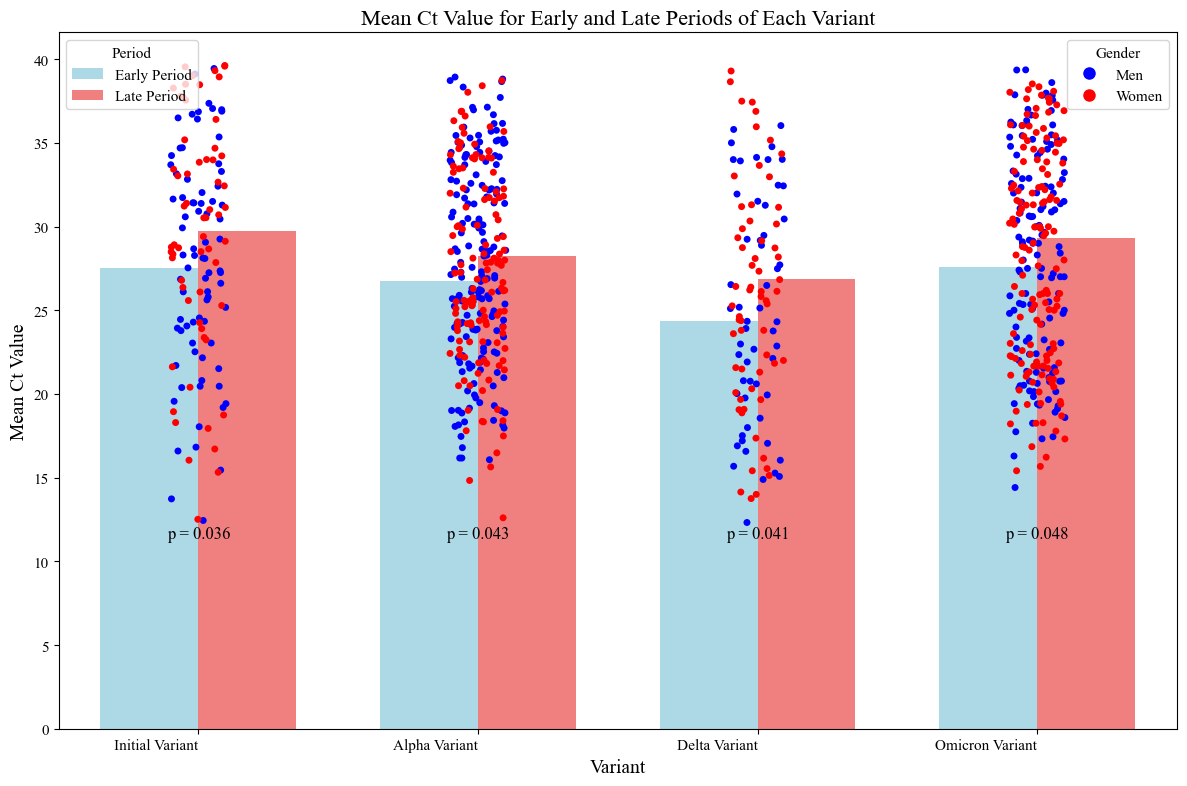

In [73]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal

# Load the Excel file
file_path = os.path.join(os.path.expanduser("~"), "Desktop", "dedomena", "ΘΕΤΙΚΑ.xlsx")
df = pd.read_excel(file_path, engine='openpyxl')

# Convert 'ct' to numeric and remove rows with invalid 'ct' values
df['ct'] = pd.to_numeric(df['ct'], errors='coerce')
df = df.dropna(subset=['date', 'ct', 'gender'])

# Convert 'date' to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

# Manual input for periods (you can change these values)
variant_periods = {
    'Initial Variant': {
        'Early': ('2020-01-01', '2020-11-21'),
        'Late': ('2020-11-22', '2021-02-5')
    },
    'Alpha Variant': {
        'Early': ('2021-02-01', '2021-04-15'),
        'Late': ('2021-04-16', '2021-07-31')
    },
    'Delta Variant': {
        'Early': ('2021-08-01', '2021-11-25'),
        'Late': ('2021-11-26', '2021-12-31')
    },
    'Omicron Variant': {
        'Early': ('2022-01-5', '2022-02-27'),
        'Late': ('2022-02-28', '2023-06-06')
    }
}

# Assign each row to the correct variant and period
def assign_variant_period(date):
    for variant, periods in variant_periods.items():
        for period, (start, end) in periods.items():
            if pd.Timestamp(start) <= date <= pd.Timestamp(end):
                return variant, period
    return None, None

df['variant'], df['period'] = zip(*df['date'].apply(assign_variant_period))
df = df.dropna(subset=['variant', 'period'])

# Group by variant period and calculate the mean ct value
ct_per_variant_period = df.groupby(['variant', 'period'])['ct'].mean().unstack()

# Ensure that 'Initial Strain' is the first in the order
ct_per_variant_period = ct_per_variant_period.reindex(['Initial Variant', 'Alpha Variant', 'Delta Variant', 'Omicron Variant'])

# Calculate the p-values for each variant using the Kruskal-Wallis test
p_values = {}
for variant in ct_per_variant_period.index:
    early_ct = df[(df['variant'] == variant) & (df['period'] == 'Early')]['ct']
    late_ct = df[(df['variant'] == variant) & (df['period'] == 'Late')]['ct']
    _, p_value = kruskal(early_ct, late_ct)  # Perform Kruskal-Wallis test
    p_values[variant] = p_value

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot bars side by side for Early and Late periods
bar_width = 0.35  # Adjusted width
positions = range(len(ct_per_variant_period.index))

# Create bars for each period
ax.bar([p - bar_width / 2 for p in positions], ct_per_variant_period['Early'], width=bar_width, label='Early Period', color='lightblue')
ax.bar([p + bar_width / 2 for p in positions], ct_per_variant_period['Late'], width=bar_width, label='Late Period', color='lightcoral')

# Add jittered dot plots for gender within the variant (not period-specific)
for p, variant in enumerate(ct_per_variant_period.index):
    variant_data = df[df['variant'] == variant]
    
    # Plot for men and women for the whole variant period (without period split)
    sns.stripplot(x=[p] * len(variant_data[variant_data['gender'] == 'man']), y=variant_data[variant_data['gender'] == 'man']['ct'], 
                  hue=variant_data[variant_data['gender'] == 'man']['gender'], dodge=False, jitter=True, marker='o', 
                  palette={'man': 'blue'}, ax=ax, legend=False)
    
    sns.stripplot(x=[p] * len(variant_data[variant_data['gender'] == 'woman']), y=variant_data[variant_data['gender'] == 'woman']['ct'], 
                  hue=variant_data[variant_data['gender'] == 'woman']['gender'], dodge=False, jitter=True, marker='o', 
                  palette={'woman': 'red'}, ax=ax, legend=False)

# Set up the axes and titles
ax.set_xticks(positions)
ax.set_xticklabels(ct_per_variant_period.index, rotation=0, ha='right')
ax.set_ylabel('Mean Ct Value', fontsize=14)
ax.set_xlabel('Variant', fontsize=14)
ax.set_title('Mean Ct Value for Early and Late Periods of Each Variant', fontsize=16)

# Display p-values on the plot
for i, (variant, p_value) in enumerate(p_values.items()):
    ax.text(i, max(ct_per_variant_period.min()) - 15.5, f'p = {p_value:.3f}', ha='center', color='black', fontsize=12)

# Add the legends for the bars and dot plots
bar_legend = ax.legend(title='Period', loc='upper left')

# Create a custom legend for the dot plots
gender_legend = ax.legend(handles=[
    plt.Line2D([0], [0], color='blue', marker='o', linestyle='', markersize=8, label='Men'),
    plt.Line2D([0], [0], color='red', marker='o', linestyle='', markersize=8, label='Women')
], title='Gender', loc='upper right')

# Add the bar legend back to the plot
ax.add_artist(bar_legend)

plt.tight_layout()
plt.show()


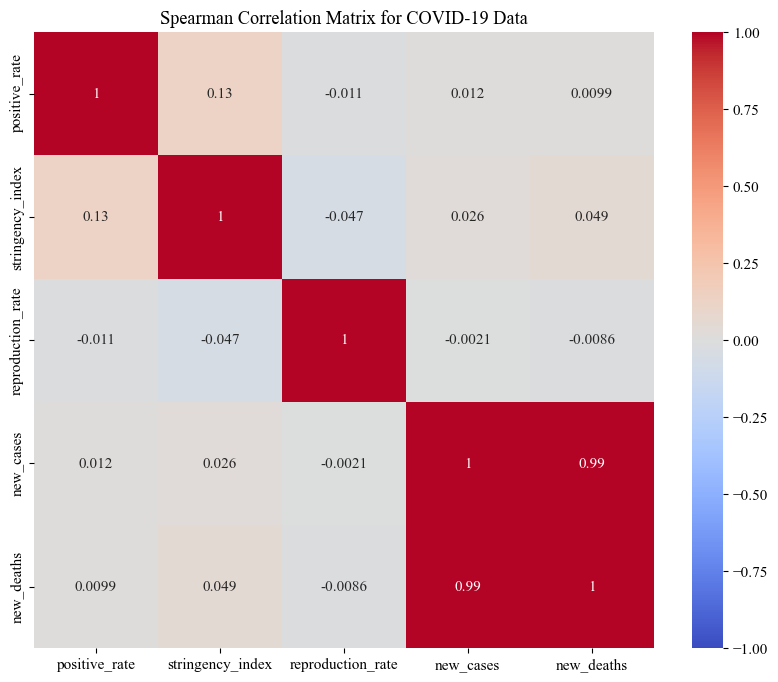

In [74]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the Excel file
file_path = os.path.join(os.path.expanduser("~"), "Desktop", "paper_host_dynamics", "owid-covid-data.xlsx")
df = pd.read_excel(file_path)

# Select the relevant columns for correlation
columns_of_interest = ['positive_rate', 'stringency_index', 'reproduction_rate', 'new_cases', 'new_deaths']
df_selected = df[columns_of_interest]

# Calculate the Spearman correlation matrix
correlation_matrix = df_selected.corr(method='spearman')

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Spearman Correlation Matrix for COVID-19 Data')
plt.show()


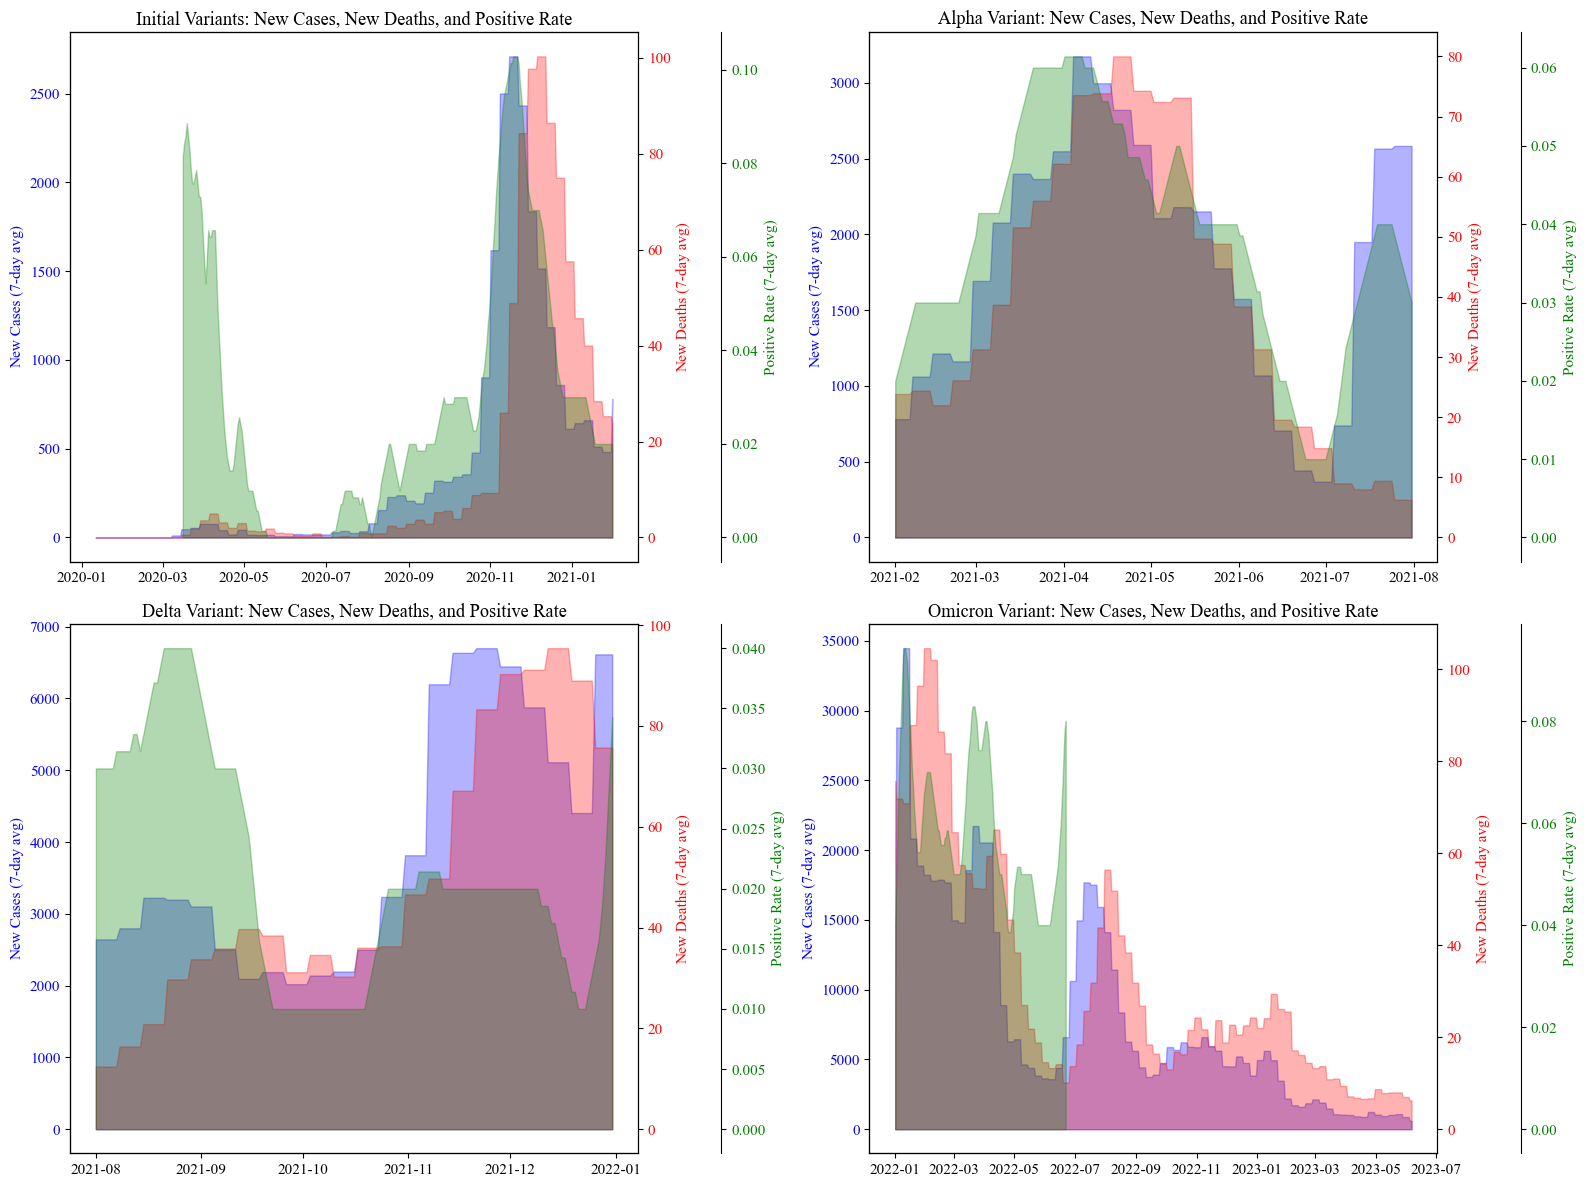

In [75]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
file_path = os.path.join(os.path.expanduser("~"), "Desktop", "paper_host_dynamics", "owid-covid-data.xlsx")
df = pd.read_excel(file_path)

# Convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Define the periods for each variant
variant_periods = {
    'Initial Variants': ('2020-01-01', '2021-01-31'),
    'Alpha Variant': ('2021-02-01', '2021-07-31'),
    'Delta Variant': ('2021-08-01', '2021-12-31'),
    'Omicron Variant': ('2022-01-01', '2023-06-06')
}

# Apply rolling averages (7-day rolling mean to smooth the data)
df['new_cases_rolling'] = df['new_cases'].rolling(window=7).mean()
df['new_deaths_rolling'] = df['new_deaths'].rolling(window=7).mean()
df['positive_rate_rolling'] = df['positive_rate'].rolling(window=7).mean()

# Create a 2x2 subplot for the four variants
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Plot each variant in a subplot
for ax, (variant, (start, end)) in zip(axes, variant_periods.items()):
    period_df = df[(df['date'] >= pd.Timestamp(start)) & (df['date'] <= pd.Timestamp(end))]

    # New Cases (smoothed area plot)
    ax.fill_between(period_df['date'], period_df['new_cases_rolling'], color='blue', alpha=0.3, label='New Cases')
    ax.set_ylabel('New Cases (7-day avg)', color='blue')
    ax.tick_params(axis='y', labelcolor='blue')

    # New Deaths (smoothed area plot)
    ax2 = ax.twinx()
    ax2.fill_between(period_df['date'], period_df['new_deaths_rolling'], color='red', alpha=0.3, label='New Deaths')
    ax2.set_ylabel('New Deaths (7-day avg)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Positive Rate (smoothed area plot)
    ax3 = ax.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.fill_between(period_df['date'], period_df['positive_rate_rolling'], color='green', alpha=0.3, label='Positive Rate')
    ax3.set_ylabel('Positive Rate (7-day avg)', color='green')
    ax3.tick_params(axis='y', labelcolor='green')

    # Title for each subplot
    ax.set_title(f'{variant}: New Cases, New Deaths, and Positive Rate')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


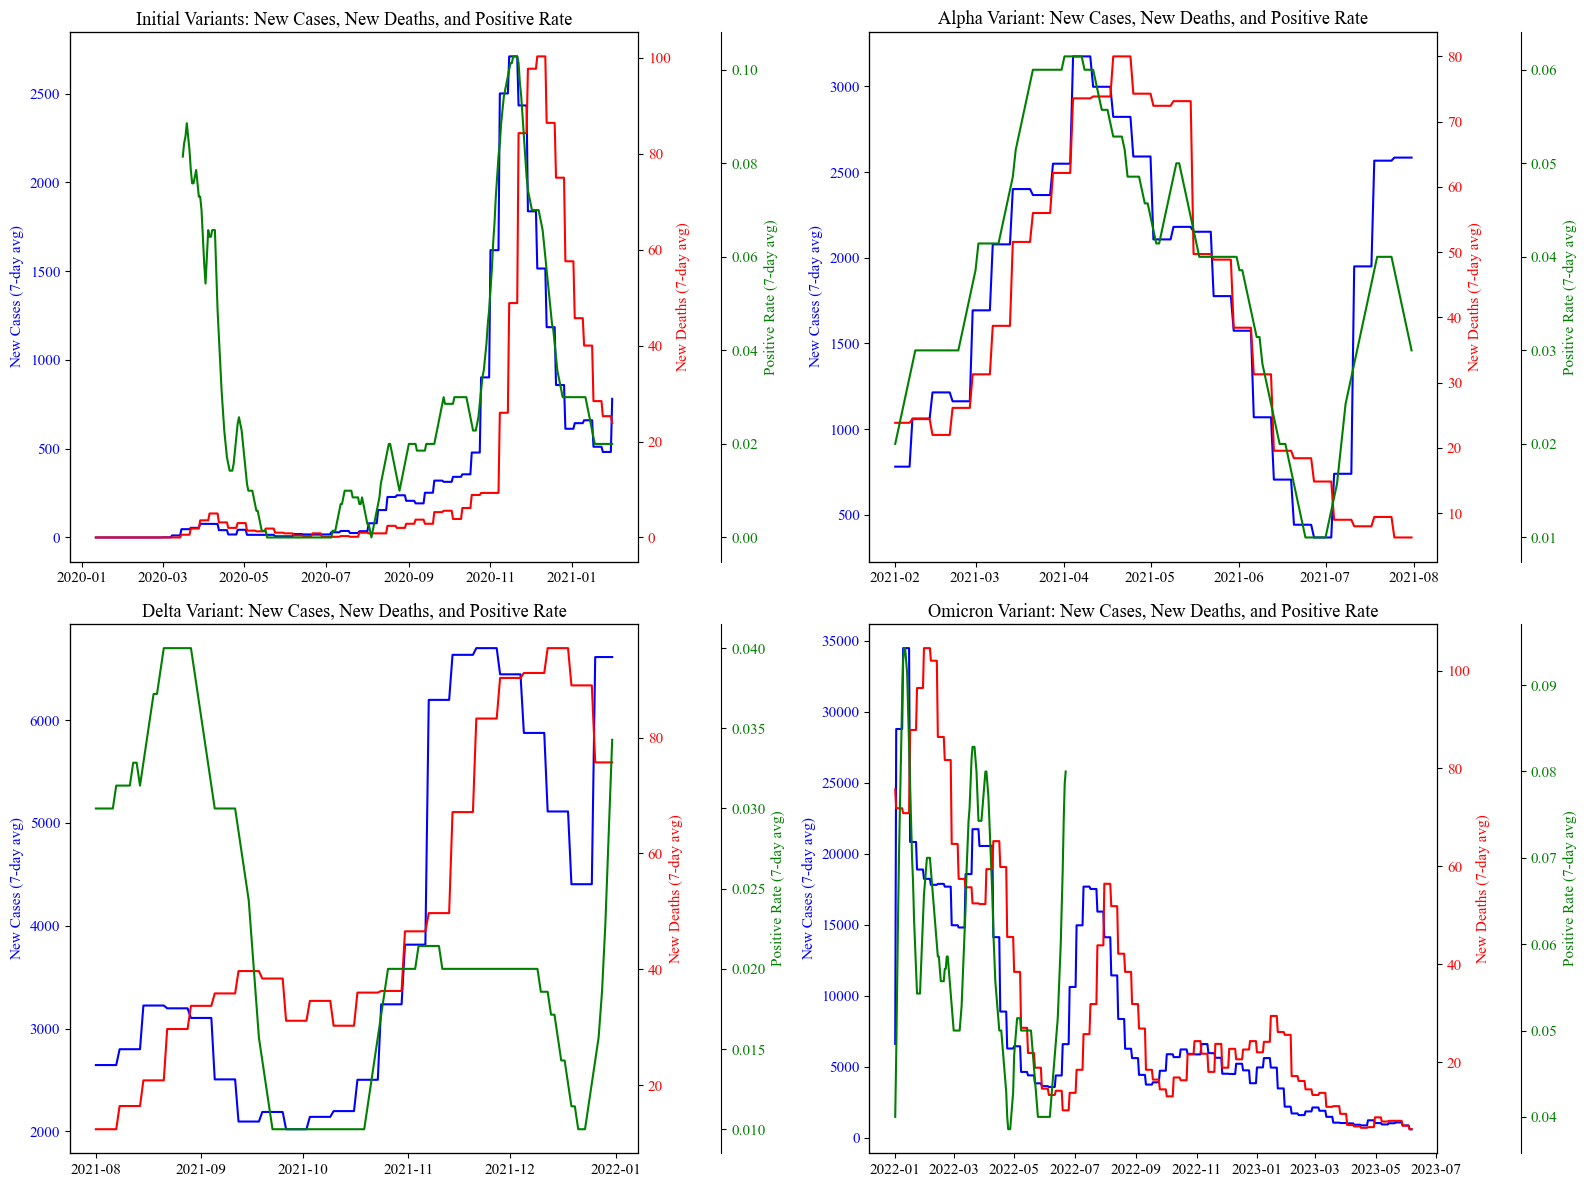

In [70]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
file_path = os.path.join(os.path.expanduser("~"), "Desktop", "paper_host_dynamics", "owid-covid-data.xlsx")
df = pd.read_excel(file_path)

# Convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Define the periods for each variant
variant_periods = {
    'Initial Variants': ('2020-01-01', '2021-01-31'),
    'Alpha Variant': ('2021-02-01', '2021-07-31'),
    'Delta Variant': ('2021-08-01', '2021-12-31'),
    'Omicron Variant': ('2022-01-01', '2023-06-06')
}

# Apply rolling averages (7-day rolling mean to smooth the data)
df['new_cases_rolling'] = df['new_cases'].rolling(window=7).mean()
df['new_deaths_rolling'] = df['new_deaths'].rolling(window=7).mean()
df['positive_rate_rolling'] = df['positive_rate'].rolling(window=7).mean()

# Create a 2x2 subplot for the four variants
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Plot each variant in a subplot
for ax, (variant, (start, end)) in zip(axes, variant_periods.items()):
    period_df = df[(df['date'] >= pd.Timestamp(start)) & (df['date'] <= pd.Timestamp(end))]

    # New Cases (smoothed line plot)
    ax.plot(period_df['date'], period_df['new_cases_rolling'], color='blue', label='New Cases')
    ax.set_ylabel('New Cases (7-day avg)', color='blue')
    ax.tick_params(axis='y', labelcolor='blue')

    # New Deaths (smoothed line plot)
    ax2 = ax.twinx()
    ax2.plot(period_df['date'], period_df['new_deaths_rolling'], color='red', label='New Deaths')
    ax2.set_ylabel('New Deaths (7-day avg)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Positive Rate (smoothed line plot)
    ax3 = ax.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.plot(period_df['date'], period_df['positive_rate_rolling'], color='green', label='Positive Rate')
    ax3.set_ylabel('Positive Rate (7-day avg)', color='green')
    ax3.tick_params(axis='y', labelcolor='green')

    # Title for each subplot
    ax.set_title(f'{variant}: New Cases, New Deaths, and Positive Rate')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


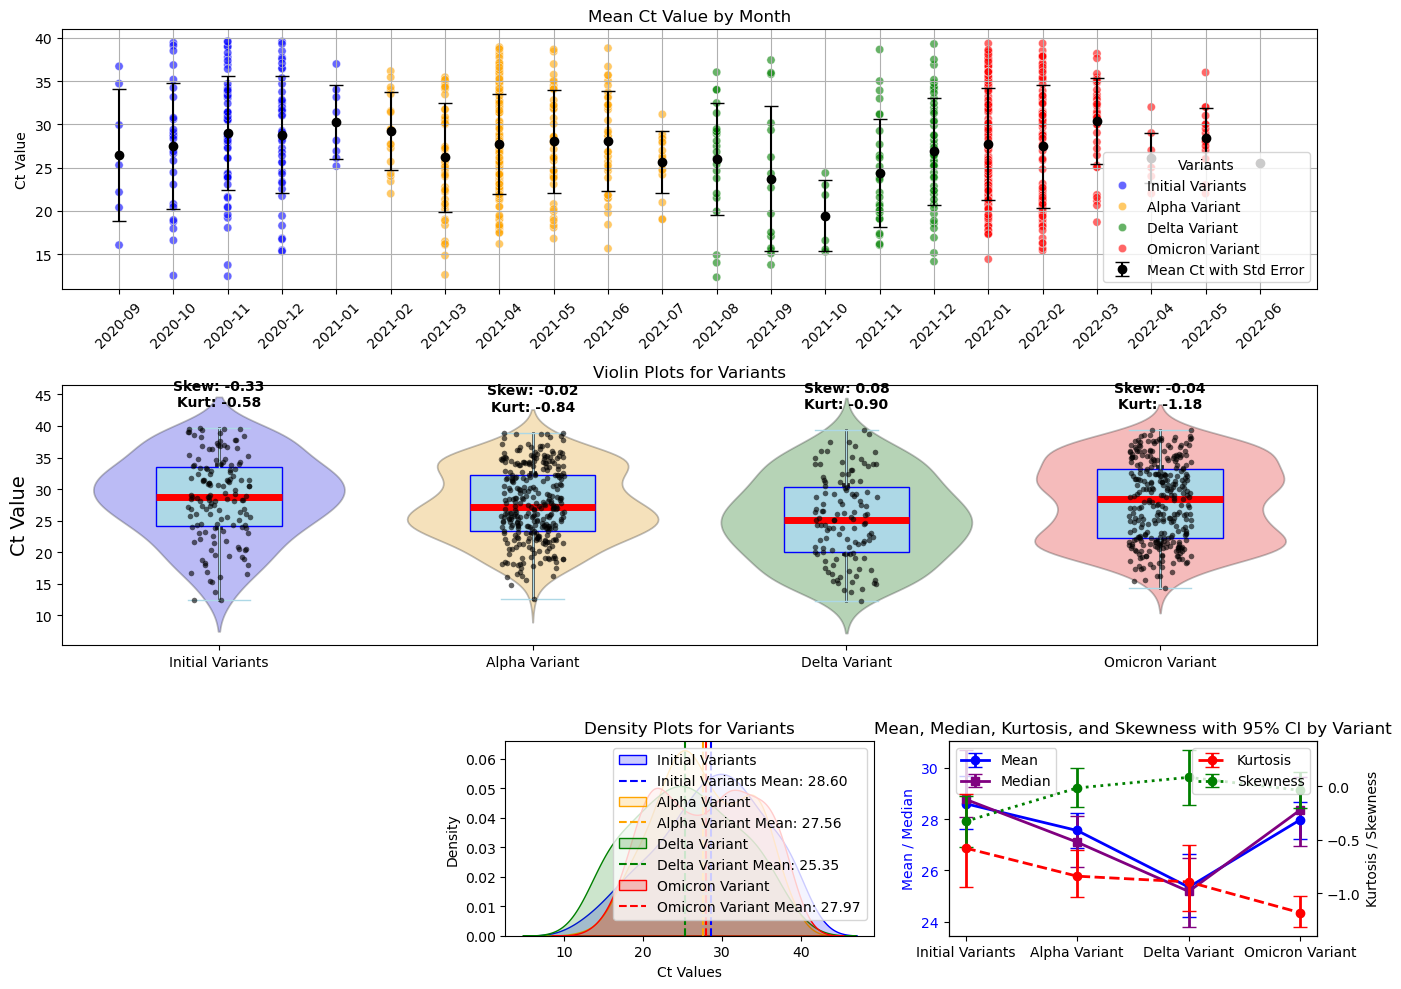

<Figure size 640x480 with 0 Axes>

In [23]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew
import numpy as np
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import seaborn as sns
from math import pi
import matplotlib.gridspec as gridspec  # Σωστή εισαγωγή του gridspec


# Φόρτωση του Excel αρχείου
file_path = os.path.join(os.path.expanduser("~"), "Desktop", "dedomena", "ΘΕΤΙΚΑ.xlsx")
df = pd.read_excel(file_path, engine='openpyxl')

# Μετατροπή των τιμών της στήλης 'ct' σε αριθμητική μορφή και αφαίρεση μη έγκυρων τιμών
df['ct'] = pd.to_numeric(df['ct'], errors='coerce')

# Αφαίρεση κενών τιμών στις στήλες που χρησιμοποιούμε
df = df.dropna(subset=['date', 'ct'])

# Μετατροπή της στήλης ημερομηνιών σε datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

# Δημιουργία στήλης 'month' για την ομαδοποίηση και μετατροπή σε συμβολοσειρά
df['month'] = df['date'].dt.to_period('M').astype(str)

# Κατηγοριοποίηση ανά παραλλαγή βάσει χρονικών περιόδων
df['variant'] = pd.cut(df['date'], 
                       bins=[pd.Timestamp('2020-01-01'), pd.Timestamp('2021-01-31'), 
                             pd.Timestamp('2021-07-31'), pd.Timestamp('2021-12-31'), pd.Timestamp('2023-10-01')],
                       labels=['Initial Variants', 'Alpha Variant', 'Delta Variant', 'Omicron Variant'], 
                       include_lowest=True)

# Αφαίρεση μη έγκυρων τιμών από τη στήλη 'variant'
df = df.dropna(subset=['variant'])

# Define a color palette for each variant
colors = {
    'Initial Variants': 'blue',
    'Alpha Variant': 'orange',
    'Delta Variant': 'green',
    'Omicron Variant': 'red'
}

# Set up a figure with subplots
plt.figure(figsize=(14, 10))

# 1. Scatter plot with error bars
gs = gridspec.GridSpec(3, 3, height_ratios=[2,2,1.5], width_ratios=[1, 1,1])

plt.subplot(gs[0, :])
#plt.subplot(2, 3, 1)
palette = colors
sns.scatterplot(data=df, x='month', y='ct', hue='variant', palette=palette, alpha=0.6)
monthly_avg = df.groupby('month').agg(Μέσος_Όρος_Ct=('ct', 'mean'), Σφάλμα=('ct', 'std')).reset_index()
plt.errorbar(monthly_avg['month'], monthly_avg['Μέσος_Όρος_Ct'], yerr=monthly_avg['Σφάλμα'], 
              fmt='o',color='black', label='Mean Ct with Std Error', capsize=5)
plt.title('Mean Ct Value by Month')
plt.xlabel('')
plt.ylabel('Ct Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Variants')

# 2. Density plots
#plt.subplot(2, 3, 2)
plt.subplot(gs[2, 1])
mean_values = {}  # Dictionary to hold mean values
for variant in df['variant'].cat.categories:
    variant_data = df[df['variant'] == variant]['ct']
    mean_value = variant_data.mean()
    mean_values[variant] = mean_value  # Store mean value
    sns.kdeplot(variant_data, label=f'{variant}', fill=True, alpha=0.2, color=colors[variant])
    plt.axvline(mean_value, linestyle='--', color=colors[variant], label=f'{variant} Mean: {mean_value:.2f}')  # Vertical line for each variant mean

plt.title('Density Plots for Variants')
plt.xlabel('Ct Values')
plt.ylabel('Density')
plt.legend()

# 3. Violin plot
#plt.subplot(2, 3,3)
plt.subplot(gs[1, :])

violin_plot = sns.violinplot(x='variant', y='ct', data=df, hue='variant', palette=colors, alpha=0.3, legend=False)

# Add dots in the violin plots
sns.stripplot(x='variant', y='ct', data=df, color='black', jitter=True, size=4, alpha=0.6)  # Dots in the violin plot

# Customize the appearance of the box inside the violin
for pc in violin_plot.patches:  # Loop through the patches (violin parts)
    pc.set_facecolor('lightcoral')  # Change this color to your desired one
    pc.set_edgecolor('red')  # Set edge color if needed

# Optionally adjust the box plot's properties (adjust this section)
plt.boxplot([df[df['variant'] == variant]['ct'] for variant in df['variant'].cat.categories],
            positions=range(len(df['variant'].cat.categories)), widths=0.4, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', color='blue'), 
            whiskerprops=dict(color='lightblue'), 
            capprops=dict(color='lightblue'), 
            medianprops=dict(color='red',linewidth=5))  # Optional for median line color

# Calculate skewness and kurtosis for each variant and annotate on the plot
for i, variant in enumerate(df['variant'].cat.categories):
    skew_val = skew(df[df['variant'] == variant]['ct'].dropna())
    kurt_val = kurtosis(df[df['variant'] == variant]['ct'].dropna())
    
   # Dynamically calculate the y position for the annotations
    y_max = df[df['variant'] == variant]['ct'].max() + 3.5  # Adjust height based on the maximum value with padding
    
    # Add text annotations for skewness and kurtosis
    plt.text(i, y_max, f'Skew: {skew_val:.2f}\nKurt: {kurt_val:.2f}', 
             horizontalalignment='center', size='medium', color='black', weight='semibold')


# Don't forget to label your axes and set the title as necessary
plt.title('Violin Plots for Variants', fontsize=14)
plt.ylabel('Ct Value', fontsize=14)
plt.xlabel('Variants', fontsize=14)


# Set x-axis labels for the variants
plt.xticks(ticks=range(len(df['variant'].cat.categories)), labels=df['variant'].cat.categories, rotation=0)

plt.title('Violin Plots for Variants')
plt.ylabel('Ct Value', fontsize=14)
plt.xlabel('', fontsize=14)
plt.tight_layout()



# 4. Kurtosis and skewness calculations
#kurtosis_values = [kurtosis(df[df['variant'] == variant]['ct'].dropna()) for variant in df['variant'].cat.categories]
#skewness_values = [skew(df[df['variant'] == variant]['ct'].dropna()) for variant in df['variant'].cat.categories]


# Συνάρτηση bootstrap για υπολογισμό διαστημάτων εμπιστοσύνης
def bootstrap_ci(data, stat_func, num_bootstrap=1000, ci_percentile=95):
    bootstrapped_stats = []
    for _ in range(num_bootstrap):
        sample = resample(data, replace=True)
        bootstrapped_stats.append(stat_func(sample))
    lower_bound = np.percentile(bootstrapped_stats, (100 - ci_percentile) / 2)
    upper_bound = np.percentile(bootstrapped_stats, 100 - (100 - ci_percentile) / 2)
    return lower_bound, upper_bound

# Υπολογισμός με bootstrap για το 95% CI για mean, median, kurtosis, skewness
variants = df['variant'].cat.categories
mean_values = []
mean_ci_lower = []
mean_ci_upper = []
median_values = []
median_ci_lower = []
median_ci_upper = []
kurtosis_values = []
kurtosis_ci_lower = []
kurtosis_ci_upper = []
skewness_values = []
skewness_ci_lower = []
skewness_ci_upper = []

for variant in variants:
    variant_data = df[df['variant'] == variant]['ct'].dropna()
    
    # Mean
    mean_value = np.mean(variant_data)
    mean_ci_l, mean_ci_u = bootstrap_ci(variant_data, np.mean)
    mean_values.append(mean_value)
    mean_ci_lower.append(mean_ci_l)
    mean_ci_upper.append(mean_ci_u)
    
    # Median
    median_value = np.median(variant_data)
    median_ci_l, median_ci_u = bootstrap_ci(variant_data, np.median)
    median_values.append(median_value)
    median_ci_lower.append(median_ci_l)
    median_ci_upper.append(median_ci_u)
    
    # Kurtosis
    kurtosis_value = kurtosis(variant_data)
    kurtosis_ci_l, kurtosis_ci_u = bootstrap_ci(variant_data, kurtosis)
    kurtosis_values.append(kurtosis_value)
    kurtosis_ci_lower.append(kurtosis_ci_l)
    kurtosis_ci_upper.append(kurtosis_ci_u)
    
    # Skewness
    skewness_value = skew(variant_data)
    skewness_ci_l, skewness_ci_u = bootstrap_ci(variant_data, skew)
    skewness_values.append(skewness_value)
    skewness_ci_lower.append(skewness_ci_l)
    skewness_ci_upper.append(skewness_ci_u)

# Σχεδιασμός γραφήματος
#plt.subplot(2, 3, 5)
plt.subplot(gs[2, 2])

# Prepare x labels and values
x_labels = df['variant'].cat.categories

# Create the first y-axis for Mean and Median with error bars
ax1 = plt.gca()

# Mean with error bars
ax1.errorbar(x_labels, mean_values, yerr=[np.array(mean_values) - np.array(mean_ci_lower), 
                                          np.array(mean_ci_upper) - np.array(mean_values)], 
             marker='o', label='Mean', color='blue', linestyle='-', linewidth=2, capsize=5)

# Median with error bars
ax1.errorbar(x_labels, median_values, yerr=[np.array(median_values) - np.array(median_ci_lower), 
                                            np.array(median_ci_upper) - np.array(median_values)], 
             marker='s', label='Median', color='purple', linestyle='-', linewidth=2, capsize=5)

ax1.set_ylabel('Mean / Median', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create the second y-axis for Kurtosis and Skewness with error bars
ax2 = ax1.twinx()  # Create a second y-axis

# Kurtosis with error bars
ax2.errorbar(x_labels, kurtosis_values, yerr=[np.array(kurtosis_values) - np.array(kurtosis_ci_lower), 
                                              np.array(kurtosis_ci_upper) - np.array(kurtosis_values)], 
             marker='o', label='Kurtosis', color='red', linestyle='--', linewidth=2, capsize=5)

# Skewness with error bars
ax2.errorbar(x_labels, skewness_values, yerr=[np.array(skewness_values) - np.array(skewness_ci_lower), 
                                              np.array(skewness_ci_upper) - np.array(skewness_values)], 
             marker='o', label='Skewness', color='green', linestyle=':', linewidth=2, capsize=5)

ax2.set_ylabel('Kurtosis / Skewness', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add labels and title
plt.title('Mean, Median, Kurtosis, and Skewness with 95% CI by Variant')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()




plt.tight_layout()
plt.show()


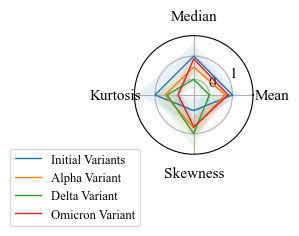

In [71]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew
import numpy as np
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import seaborn as sns
from math import pi
import matplotlib.gridspec as gridspec  # Σωστή εισαγωγή του gridspec

import matplotlib.pyplot as plt

# Set the default font family and size
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 11

# Φόρτωση του Excel αρχείου
file_path = os.path.join(os.path.expanduser("~"), "Desktop", "dedomena", "ΘΕΤΙΚΑ.xlsx")
df = pd.read_excel(file_path, engine='openpyxl')

# Μετατροπή των τιμών της στήλης 'ct' σε αριθμητική μορφή και αφαίρεση μη έγκυρων τιμών
df['ct'] = pd.to_numeric(df['ct'], errors='coerce')

# Αφαίρεση κενών τιμών στις στήλες που χρησιμοποιούμε
df = df.dropna(subset=['date', 'ct'])

# Μετατροπή της στήλης ημερομηνιών σε datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

# Δημιουργία στήλης 'month' για την ομαδοποίηση και μετατροπή σε συμβολοσειρά
df['month'] = df['date'].dt.to_period('M').astype(str)

# Κατηγοριοποίηση ανά παραλλαγή βάσει χρονικών περιόδων
df['variant'] = pd.cut(df['date'], 
                       bins=[pd.Timestamp('2020-01-01'), pd.Timestamp('2021-01-31'), 
                             pd.Timestamp('2021-07-31'), pd.Timestamp('2021-12-31'), pd.Timestamp('2023-10-01')],
                       labels=['Initial Variants', 'Alpha Variant', 'Delta Variant', 'Omicron Variant'], 
                       include_lowest=True)

# Αφαίρεση μη έγκυρων τιμών από τη στήλη 'variant'
df = df.dropna(subset=['variant'])

# Define a color palette for each variant
colors = {
    'Initial Variants': 'blue',
    'Alpha Variant': 'orange',
    'Delta Variant': 'green',
    'Omicron Variant': 'red'
}



# 4. Kurtosis and skewness calculations
#kurtosis_values = [kurtosis(df[df['variant'] == variant]['ct'].dropna()) for variant in df['variant'].cat.categories]
#skewness_values = [skew(df[df['variant'] == variant]['ct'].dropna()) for variant in df['variant'].cat.categories]


# Συνάρτηση bootstrap για υπολογισμό διαστημάτων εμπιστοσύνης
def bootstrap_ci(data, stat_func, num_bootstrap=1000, ci_percentile=95):
    bootstrapped_stats = []
    for _ in range(num_bootstrap):
        sample = resample(data, replace=True)
        bootstrapped_stats.append(stat_func(sample))
    lower_bound = np.percentile(bootstrapped_stats, (100 - ci_percentile) / 2)
    upper_bound = np.percentile(bootstrapped_stats, 100 - (100 - ci_percentile) / 2)
    return lower_bound, upper_bound

# Υπολογισμός με bootstrap για το 95% CI για mean, median, kurtosis, skewness
variants = df['variant'].cat.categories
mean_values = []
mean_ci_lower = []
mean_ci_upper = []
median_values = []
median_ci_lower = []
median_ci_upper = []
kurtosis_values = []
kurtosis_ci_lower = []
kurtosis_ci_upper = []
skewness_values = []
skewness_ci_lower = []
skewness_ci_upper = []

for variant in variants:
    variant_data = df[df['variant'] == variant]['ct'].dropna()
    
    # Mean
    mean_value = np.mean(variant_data)
    mean_ci_l, mean_ci_u = bootstrap_ci(variant_data, np.mean)
    mean_values.append(mean_value)
    mean_ci_lower.append(mean_ci_l)
    mean_ci_upper.append(mean_ci_u)
    
    # Median
    median_value = np.median(variant_data)
    median_ci_l, median_ci_u = bootstrap_ci(variant_data, np.median)
    median_values.append(median_value)
    median_ci_lower.append(median_ci_l)
    median_ci_upper.append(median_ci_u)
    
    # Kurtosis
    kurtosis_value = kurtosis(variant_data)
    kurtosis_ci_l, kurtosis_ci_u = bootstrap_ci(variant_data, kurtosis)
    kurtosis_values.append(kurtosis_value)
    kurtosis_ci_lower.append(kurtosis_ci_l)
    kurtosis_ci_upper.append(kurtosis_ci_u)
    
    # Skewness
    skewness_value = skew(variant_data)
    skewness_ci_l, skewness_ci_u = bootstrap_ci(variant_data, skew)
    skewness_values.append(skewness_value)
    skewness_ci_lower.append(skewness_ci_l)
    skewness_ci_upper.append(skewness_ci_u)





#
# Υπολογισμός με bootstrap για το 95% CI για mean, median, kurtosis, skewness
variants = df['variant'].cat.categories
mean_values = []
mean_ci_lower = []
mean_ci_upper = []
median_values = []
median_ci_lower = []
median_ci_upper = []
kurtosis_values = []
kurtosis_ci_lower = []
kurtosis_ci_upper = []
skewness_values = []
skewness_ci_lower = []
skewness_ci_upper = []

for variant in variants:
    variant_data = df[df['variant'] == variant]['ct'].dropna()
    
    # Mean
    mean_value = np.mean(variant_data)
    mean_ci_l, mean_ci_u = bootstrap_ci(variant_data, np.mean)
    mean_values.append(mean_value)
    mean_ci_lower.append(mean_ci_l)
    mean_ci_upper.append(mean_ci_u)
    
    # Median
    median_value = np.median(variant_data)
    median_ci_l, median_ci_u = bootstrap_ci(variant_data, np.median)
    median_values.append(median_value)
    median_ci_lower.append(median_ci_l)
    median_ci_upper.append(median_ci_u)
    
    # Kurtosis
    kurtosis_value = kurtosis(variant_data)
    kurtosis_ci_l, kurtosis_ci_u = bootstrap_ci(variant_data, kurtosis)
    kurtosis_values.append(kurtosis_value)
    kurtosis_ci_lower.append(kurtosis_ci_l)
    kurtosis_ci_upper.append(kurtosis_ci_u)
    
    # Skewness
    skewness_value = skew(variant_data)
    skewness_ci_l, skewness_ci_u = bootstrap_ci(variant_data, skew)
    skewness_values.append(skewness_value)
    skewness_ci_lower.append(skewness_ci_l)
    skewness_ci_upper.append(skewness_ci_u)

# 4. Radar chart με κλίμακα για καλύτερη ορατότητα
#ax=plt.subplot(2, 3, 6, polar=True)

ax=plt.subplot(gs[0, :], polar=True)

# Κανονικοποίηση των τιμών και των διαστημάτων εμπιστοσύνης με MinMaxScaler
scaler = MinMaxScaler()

# Συγκέντρωση των δεδομένων σε έναν πίνακα για κανονικοποίηση
data = np.array([mean_values, median_values, kurtosis_values, skewness_values]).T
lower_bounds = np.array([mean_ci_lower, median_ci_lower, kurtosis_ci_lower, skewness_ci_lower]).T
upper_bounds = np.array([mean_ci_upper, median_ci_upper, kurtosis_ci_upper, skewness_ci_upper]).T

# Κανονικοποίηση των κεντρικών τιμών, lower bounds, και upper bounds
data_normalized = scaler.fit_transform(data)
lower_bounds_normalized = scaler.transform(lower_bounds)
upper_bounds_normalized = scaler.transform(upper_bounds)

# Κατηγορίες (Mean, Median, Kurtosis, Skewness)
categories = ['Mean', 'Median', 'Kurtosis', 'Skewness']
N = len(categories)

# Γωνίες για το radar chart
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]


for i in range(len(variants)):
    # Κανονικοποιημένες τιμές
    values = data_normalized[i].tolist()
    values += values[:1]  # Επαναλαμβάνουμε το πρώτο στοιχείο για να κλείσει το γράφημα

    # Κανονικοποιημένα lower και upper bounds για τα CI
    lower_values = lower_bounds_normalized[i].tolist()
    lower_values += lower_values[:1]
    upper_values = upper_bounds_normalized[i].tolist()
    upper_values += upper_values[:1]

    # Plot των κανονικοποιημένων τιμών
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=variants[i])
    
    # Προσθήκη error bands (περιοχή ανάμεσα στα CI)
    ax.fill_between(angles, lower_values, upper_values, alpha=0.1)

# Προσθήκη κατηγοριών στις ακτίνες
plt.xticks(angles[:-1], categories)

# Προσθήκη τίτλου και υπομνήματος
#plt.title('Normalized Radar Chart with CI',fontsize='small')
ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1),fontsize='small')

#plt.tight_layout()
plt.show()


ValueError: 'yerr' must not contain negative values

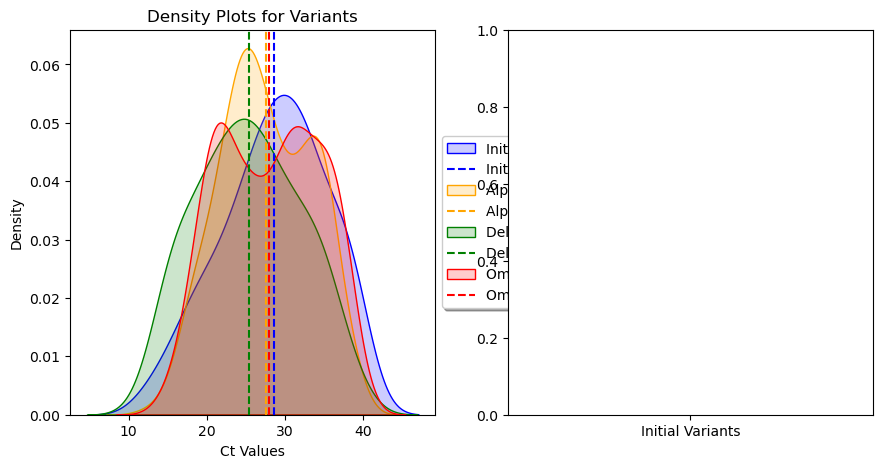

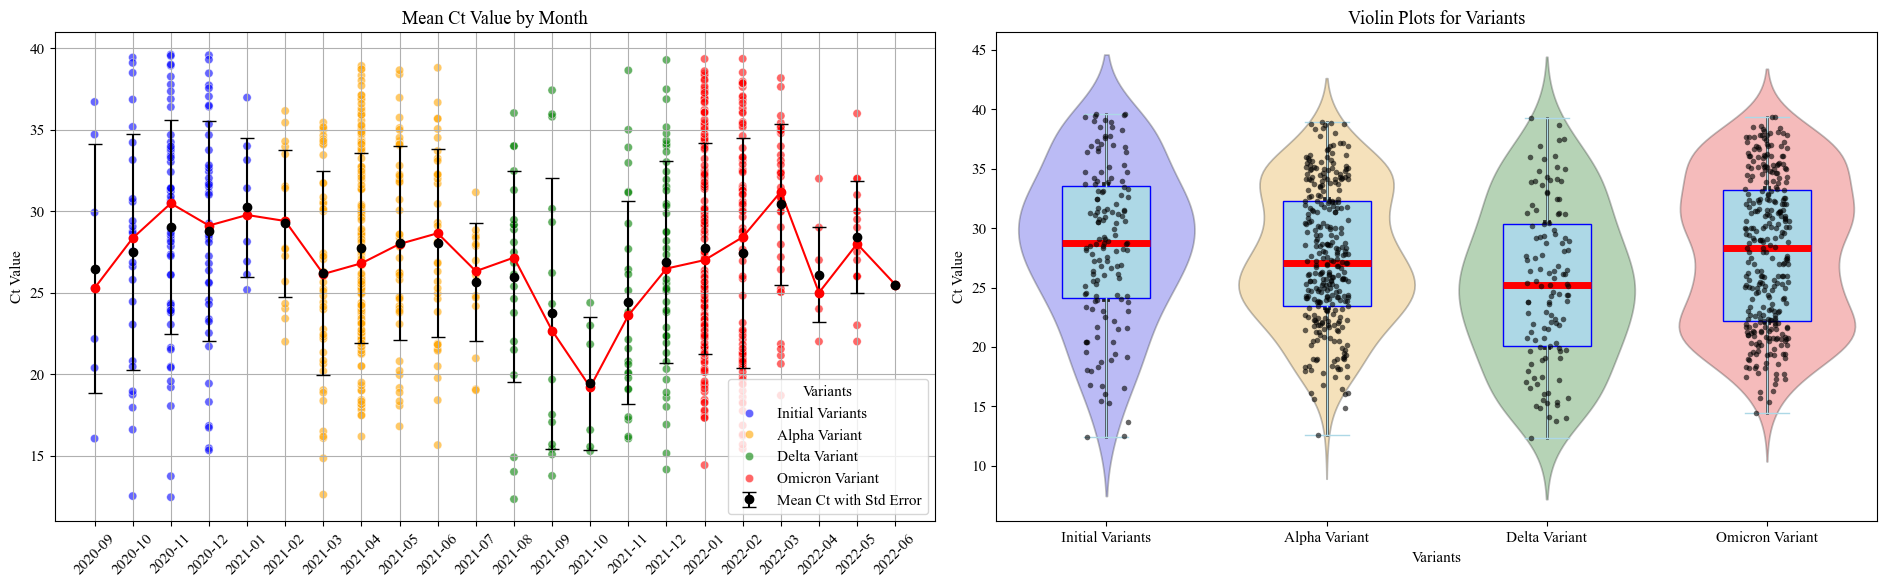

In [68]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew
from math import pi
import matplotlib.pyplot as plt

# Set the default font family and size
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 11

# Φόρτωση του Excel αρχείου
file_path = os.path.join(os.path.expanduser("~"), "Desktop", "dedomena", "ΘΕΤΙΚΑ.xlsx")
df = pd.read_excel(file_path, engine='openpyxl')

# Μετατροπή των τιμών της στήλης 'ct' σε αριθμητική μορφή και αφαίρεση μη έγκυρων τιμών
df['ct'] = pd.to_numeric(df['ct'], errors='coerce')

# Αφαίρεση κενών τιμών στις στήλες που χρησιμοποιούμε
df = df.dropna(subset=['date', 'ct'])

# Μετατροπή της στήλης ημερομηνιών σε datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

# Δημιουργία στήλης 'month' για την ομαδοποίηση και μετατροπή σε συμβολοσειρά
df['month'] = df['date'].dt.to_period('M').astype(str)

# Κατηγοριοποίηση ανά παραλλαγή βάσει χρονικών περιόδων
df['variant'] = pd.cut(df['date'], 
                       bins=[pd.Timestamp('2020-01-01'), pd.Timestamp('2021-01-31'), pd.Timestamp('2021-07-31'), pd.Timestamp('2021-12-31'), pd.Timestamp('2023-10-01')],
                       labels=['Initial Variants', 'Alpha Variant', 'Delta Variant', 'Omicron Variant'], 
                       include_lowest=True)

# Αφαίρεση μη έγκυρων τιμών από τη στήλη 'variant'
df = df.dropna(subset=['variant'])

# Define a color palette for each variant
colors = {
    'Initial Variants': 'blue',
    'Alpha Variant': 'orange',
    'Delta Variant': 'green',
    'Omicron Variant': 'red'
}

# Set up a figure with subplots
plt.figure(figsize=(19, 6))

# 1. Scatter plot with error bars
plt.subplot(1, 2, 1)
palette = colors
sns.scatterplot(data=df, x='month', y='ct', hue='variant', palette=palette, alpha=0.6)
monthly_avg = df.groupby('month').agg(Μέσος_Όρος_Ct=('ct', 'mean'), Σφάλμα=('ct', 'std')).reset_index()
plt.errorbar(monthly_avg['month'], monthly_avg['Μέσος_Όρος_Ct'], yerr=monthly_avg['Σφάλμα'], 
              fmt='o', color='black', label='Mean Ct with Std Error', capsize=5)
plt.title('Mean Ct Value by Month')
plt.xlabel('')
plt.ylabel('Ct Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Variants')

monthly_median = df.groupby('month').agg(Median_Ct=('ct', 'median')).reset_index()

plt.plot(monthly_median['month'], monthly_median['Median_Ct'], linestyle='-', marker='o', color='red', label='Median Ct')


# 3. Violin plot (Διατήρηση του αρχικού σας σχεδίου)
plt.subplot(1, 2, 2)
violin_plot = sns.violinplot(x='variant', y='ct', data=df, hue='variant', palette=colors, alpha=0.3, legend=False)

# Add dots in the violin plots
sns.stripplot(x='variant', y='ct', data=df, color='black', jitter=True, size=4, alpha=0.6)  # Dots in the violin plot

# Διατήρηση της παραμετροποίησης του box plot
plt.boxplot([df[df['variant'] == variant]['ct'] for variant in df['variant'].cat.categories],
            positions=range(len(df['variant'].cat.categories)), widths=0.4, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', color='blue'), 
            whiskerprops=dict(color='lightblue'), 
            capprops=dict(color='lightblue'), 
            medianprops=dict(color='red', linewidth=5))

plt.title('Violin Plots for Variants')
plt.ylabel('Ct Value')
plt.xlabel('Variants')

plt.xticks(ticks=range(len(df['variant'].cat.categories)), labels=df['variant'].cat.categories, rotation=0)
plt.tight_layout()

#_ci_upper.append(skewness_ci_u)



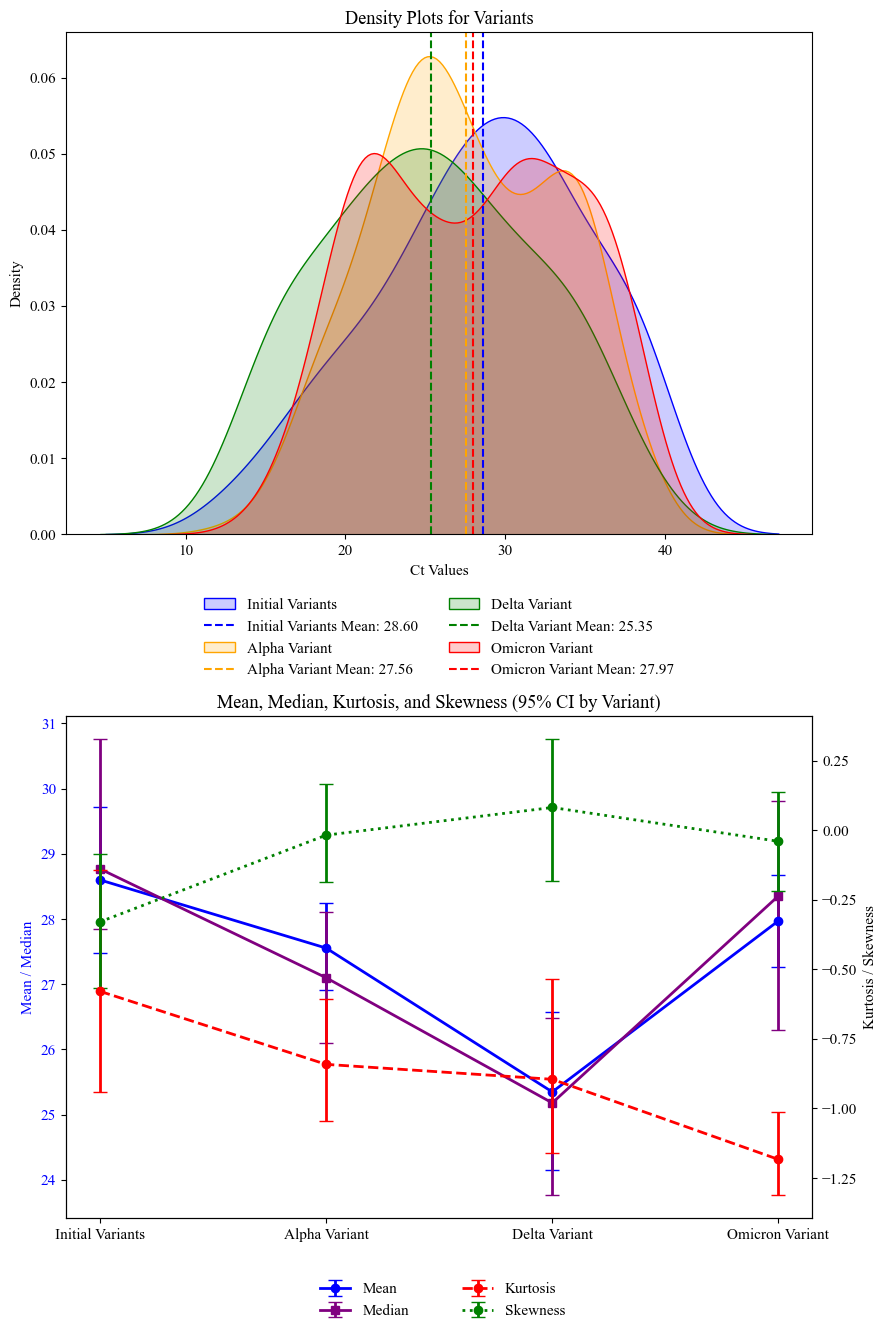

<Figure size 640x480 with 0 Axes>

In [66]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew
import numpy as np
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import seaborn as sns
from math import pi
import matplotlib.gridspec as gridspec  # Σωστή εισαγωγή του gridspec

import matplotlib.pyplot as plt

# Set the default font family and size
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 11

# Φόρτωση του Excel αρχείου
file_path = os.path.join(os.path.expanduser("~"), "Desktop", "dedomena", "ΘΕΤΙΚΑ.xlsx")
df = pd.read_excel(file_path, engine='openpyxl')

# Μετατροπή των τιμών της στήλης 'ct' σε αριθμητική μορφή και αφαίρεση μη έγκυρων τιμών
df['ct'] = pd.to_numeric(df['ct'], errors='coerce')

# Αφαίρεση κενών τιμών στις στήλες που χρησιμοποιούμε
df = df.dropna(subset=['date', 'ct'])

# Μετατροπή της στήλης ημερομηνιών σε datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

# Δημιουργία στήλης 'month' για την ομαδοποίηση και μετατροπή σε συμβολοσειρά
df['month'] = df['date'].dt.to_period('M').astype(str)

# Κατηγοριοποίηση ανά παραλλαγή βάσει χρονικών περιόδων
df['variant'] = pd.cut(df['date'], 
                       bins=[pd.Timestamp('2020-01-01'), pd.Timestamp('2021-01-31'), 
                             pd.Timestamp('2021-07-31'), pd.Timestamp('2021-12-31'), pd.Timestamp('2023-10-01')],
                       labels=['Initial Variants', 'Alpha Variant', 'Delta Variant', 'Omicron Variant'], 
                       include_lowest=True)

# Αφαίρεση μη έγκυρων τιμών από τη στήλη 'variant'
df = df.dropna(subset=['variant'])

# Define a color palette for each variant
colors = {
    'Initial Variants': 'blue',
    'Alpha Variant': 'orange',
    'Delta Variant': 'green',
    'Omicron Variant': 'red'
}

# Set up a figure with subplots
plt.figure(figsize=(9, 18))



# 2. Density plots
#plt.subplot(2, 3, 2)
plt.subplot(gs[0, :])
mean_values = {}  # Dictionary to hold mean values
for variant in df['variant'].cat.categories:
    variant_data = df[df['variant'] == variant]['ct']
    mean_value = variant_data.mean()
    mean_values[variant] = mean_value  # Store mean value
    sns.kdeplot(variant_data, label=f'{variant}', fill=True, alpha=0.2, color=colors[variant])
    plt.axvline(mean_value, linestyle='--', color=colors[variant], label=f'{variant} Mean: {mean_value:.2f}')  # Vertical line for each variant mean

plt.title('Density Plots for Variants')
plt.xlabel('Ct Values')
plt.ylabel('Density')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),frameon=False, fancybox=True, shadow=True, ncol=2)



# 4. Kurtosis and skewness calculations
#kurtosis_values = [kurtosis(df[df['variant'] == variant]['ct'].dropna()) for variant in df['variant'].cat.categories]
#skewness_values = [skew(df[df['variant'] == variant]['ct'].dropna()) for variant in df['variant'].cat.categories]


# Συνάρτηση bootstrap για υπολογισμό διαστημάτων εμπιστοσύνης
def bootstrap_ci(data, stat_func, num_bootstrap=1000, ci_percentile=95):
    bootstrapped_stats = []
    for _ in range(num_bootstrap):
        sample = resample(data, replace=True)
        bootstrapped_stats.append(stat_func(sample))
    lower_bound = np.percentile(bootstrapped_stats, (100 - ci_percentile) / 2)
    upper_bound = np.percentile(bootstrapped_stats, 100 - (100 - ci_percentile) / 2)
    return lower_bound, upper_bound

# Υπολογισμός με bootstrap για το 95% CI για mean, median, kurtosis, skewness
variants = df['variant'].cat.categories
mean_values = []
mean_ci_lower = []
mean_ci_upper = []
median_values = []
median_ci_lower = []
median_ci_upper = []
kurtosis_values = []
kurtosis_ci_lower = []
kurtosis_ci_upper = []
skewness_values = []
skewness_ci_lower = []
skewness_ci_upper = []

for variant in variants:
    variant_data = df[df['variant'] == variant]['ct'].dropna()
    
    # Mean
    mean_value = np.mean(variant_data)
    mean_ci_l, mean_ci_u = bootstrap_ci(variant_data, np.mean)
    mean_values.append(mean_value)
    mean_ci_lower.append(mean_ci_l)
    mean_ci_upper.append(mean_ci_u)
    
    # Median
    median_value = np.median(variant_data)
    median_ci_l, median_ci_u = bootstrap_ci(variant_data, np.median)
    median_values.append(median_value)
    median_ci_lower.append(median_ci_l)
    median_ci_upper.append(median_ci_u)
    
    # Kurtosis
    kurtosis_value = kurtosis(variant_data)
    kurtosis_ci_l, kurtosis_ci_u = bootstrap_ci(variant_data, kurtosis)
    kurtosis_values.append(kurtosis_value)
    kurtosis_ci_lower.append(kurtosis_ci_l)
    kurtosis_ci_upper.append(kurtosis_ci_u)
    
    # Skewness
    skewness_value = skew(variant_data)
    skewness_ci_l, skewness_ci_u = bootstrap_ci(variant_data, skew)
    skewness_values.append(skewness_value)
    skewness_ci_lower.append(skewness_ci_l)
    skewness_ci_upper.append(skewness_ci_u)

# Σχεδιασμός γραφήματος
#plt.subplot(2, 3, 5)
plt.subplot(gs[1, :])

# Prepare x labels and values
x_labels = df['variant'].cat.categories

# Create the first y-axis for Mean and Median with error bars
ax1 = plt.gca()

# Mean with error bars
ax1.errorbar(x_labels, mean_values, yerr=[np.array(mean_values) - np.array(mean_ci_lower), 
                                          np.array(mean_ci_upper) - np.array(mean_values)], 
             marker='o', label='Mean', color='blue', linestyle='-', linewidth=2, capsize=5)

# Median with error bars
ax1.errorbar(x_labels, median_values, yerr=[np.array(median_values) - np.array(median_ci_lower), 
                                            np.array(median_ci_upper) - np.array(median_values)], 
             marker='s', label='Median', color='purple', linestyle='-', linewidth=2, capsize=5)

ax1.set_ylabel('Mean / Median', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create the second y-axis for Kurtosis and Skewness with error bars
ax2 = ax1.twinx()  # Create a second y-axis

# Kurtosis with error bars
ax2.errorbar(x_labels, kurtosis_values, yerr=[np.array(kurtosis_values) - np.array(kurtosis_ci_lower), 
                                              np.array(kurtosis_ci_upper) - np.array(kurtosis_values)], 
             marker='o', label='Kurtosis', color='red', linestyle='--', linewidth=2, capsize=5)

# Skewness with error bars
ax2.errorbar(x_labels, skewness_values, yerr=[np.array(skewness_values) - np.array(skewness_ci_lower), 
                                              np.array(skewness_ci_upper) - np.array(skewness_values)], 
             marker='o', label='Skewness', color='green', linestyle=':', linewidth=2, capsize=5)

ax2.set_ylabel('Kurtosis / Skewness', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add labels and title
plt.title('Mean, Median, Kurtosis, and Skewness (95% CI by Variant)')
ax1.legend(loc='upper center', bbox_to_anchor=(0.4, -0.1),frameon=False, fancybox=True, shadow=True)
ax2.legend(loc='upper center', bbox_to_anchor=(0.6, -0.1), frameon=False,fancybox=True, shadow=True)

plt.tight_layout()
plt.show()

#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)



plt.tight_layout()
plt.show()
